In [84]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tabulate import tabulate

plt.style.use("../auri.mplstyle")

pd.options.display.unicode.east_asian_width = True

In [86]:
parquet_path = Path("../data/processed/기본개요_표제부_단독주건축물.parquet")
df = pd.read_parquet(parquet_path)
print(f"Loaded shape: {df.shape}")
df.head()

Loaded shape: (5456295, 11)


,관리_건축물대장_PK,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),높이(m),지상_층_수,지하_층_수,사용승인_일
0,1201126395,NaN,32.00,NaN,32.00,32.00,NaN,NaN,1,0,19200101
1,1201126431,NaN,60.53,NaN,60.53,60.53,NaN,NaN,1,0,19780101
2,1201126436,456.0,98.19,21.53,98.19,98.19,21.53,NaN,1,0,20031114
3,1201126437,377.0,114.68,30.42,98.35,98.35,26.09,NaN,1,0,20001120
4,1201126442,NaN,129.60,NaN,129.60,129.60,NaN,NaN,1,0,18810101


In [87]:
df.dtypes

관리_건축물대장_PK          object
대지_면적(㎡)              float64
건축_면적(㎡)              float64
건폐_율(%)                 float64
연면적(㎡)                 float64
용적_률_산정_연면적(㎡)    float64
용적_률(%)                 float64
높이(m)                    float64
지상_층_수                   int32
지하_층_수                   int32
사용승인_일                 object
dtype: object

In [ ]:
# simple sampling

# sampled = df.sample(n=10_000, replace=False, random_state=1106)

In [88]:
def stratified_sample(df, stratum_col, n, min_per_stratum=5, random_state=1106):
    counts = df[stratum_col].value_counts()
    N = counts.sum()
    # proportional allocation
    alloc = (n * counts / N).round().astype(int).clip(lower=min_per_stratum)
    # cap by available rows
    alloc = np.minimum(alloc, counts)
    # draw
    parts = []
    rng = np.random.default_rng(random_state)
    for h, k in alloc.items():
        grp = df[df[stratum_col] == h]
        parts.append(grp.sample(n=k, random_state=rng.integers(0, 1 << 32)))
    out = pd.concat(parts, ignore_index=True)
    return out


# usage
# df['stratum'] = pd.qcut(df['x'], q=20, duplicates='drop')  # if stratifying by quantiles
# sampled = stratified_sample(df, "label", n=10_000)

In [100]:
df["건축_면적_이상"] = df["건축_면적(㎡)"] > df["대지_면적(㎡)"]

sampled = stratified_sample(df, "건축_면적_이상", n=10_000, min_per_stratum=1_000)
sampled

,관리_건축물대장_PK,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),높이(m),지상_층_수,지하_층_수,사용승인_일,건축_면적_이상
0,1110136633,753.0,330.43,43.88,1132.52,774.96,102.92,13.70,3,1,19861129,False
1,1268131774,912.1,160.17,17.56,170.01,142.71,15.65,7.95,2,0,20070619,False
2,125211000036641,NaN,NaN,NaN,132.89,132.89,66.44,NaN,2,0,19760924,False
3,1205123431,NaN,68.43,NaN,68.43,68.43,NaN,NaN,1,0,1977,False
4,1229164043,NaN,62.20,NaN,62.20,62.20,NaN,NaN,1,0,1947,False
...,...,...,...,...,...,...,...,...,...,...,...,...
10981,1082117139,45.0,115.81,NaN,115.81,115.81,NaN,NaN,1,0,1991,True
10982,1201121831,82.0,95.45,116.40,95.45,95.45,116.40,NaN,1,0,19640730,True
10983,1170132000,109.0,184.95,169.68,184.95,184.95,169.68,NaN,1,0,19890311,True
10984,1047111222,69.0,76.21,110.45,76.21,76.21,110.45,4.70,1,0,19850502,True


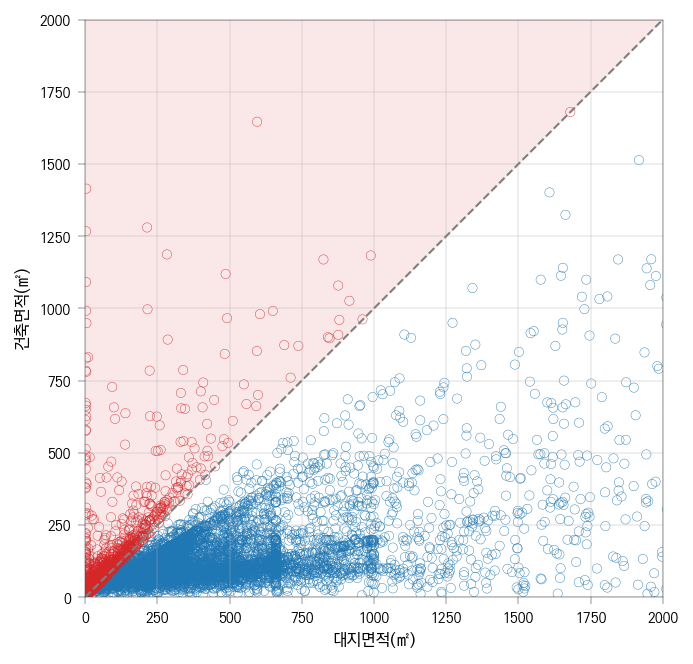

In [113]:
sampled = stratified_sample(df, "건축_면적_이상", n=10_000, min_per_stratum=1_000)

# Scatterplot of "대지_면적(㎡)" vs "건축_면적(㎡)"
plt.figure(figsize=(5, 5))
colors = sampled["건축_면적_이상"].map({True: "tab:red", False: "tab:blue"})
plt.scatter(
    sampled["대지_면적(㎡)"],
    sampled["건축_면적(㎡)"],
    edgecolors=colors,
    facecolors="none",
    s=20,
)

max_val = sampled["건축_면적(㎡)"].max()
max_val = 2000
plt.xlim(0, max_val)
plt.ylim(0, max_val)

# 45-degree line
plt.plot([0, max_val], [0, max_val], color="tab:gray", linestyle="--", linewidth=1)

# Shade area above the 45-degree line
plt.fill_between(
    [0, max_val],
    [max_val, max_val],
    [0, max_val],
    color="tab:red",
    alpha=0.10,
    zorder=0,
)
# plt.xscale("log")
# plt.yscale("log")

plt.gca().set_aspect("equal")
plt.xlabel("대지면적(㎡)")
plt.ylabel("건축면적(㎡)")
# plt.title("대지 면적과 건축 면적 산점도")
plt.grid(True)

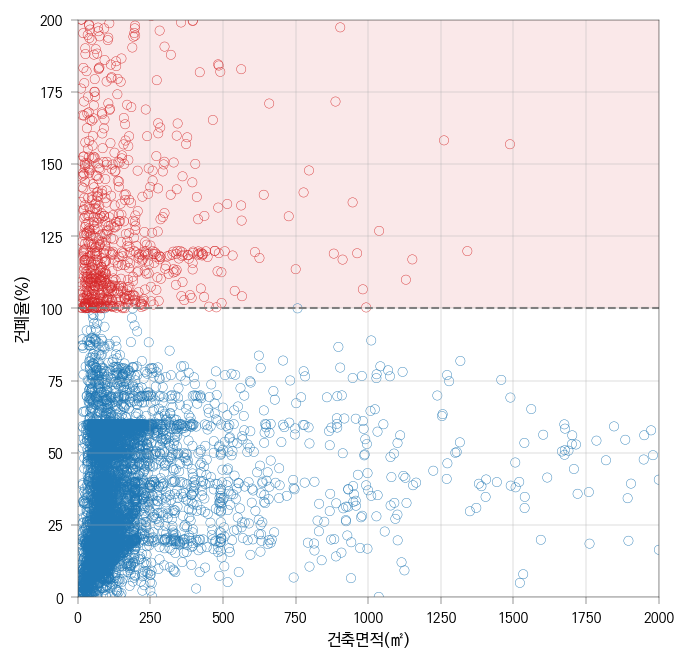

In [122]:
df["건폐율_이상"] = df["건폐_율(%)"] > 100
sampled = stratified_sample(df, "건폐율_이상", n=10_000, min_per_stratum=1_000)

plt.figure(figsize=(5, 5))
colors = sampled["건폐율_이상"].map({True: "tab:red", False: "tab:blue"})
plt.scatter(
    sampled["건축_면적(㎡)"],
    sampled["건폐_율(%)"],
    edgecolors=colors,
    facecolors="none",
    s=20,
)
max_xval = 2000
max_yval = 200
plt.xlim(0, max_xval)
plt.ylim(0, max_yval)

# line
plt.plot([0, max_xval], [100, 100], color="tab:gray", linestyle="--", linewidth=1)

# Shade area above the line
plt.fill_between(
    [0, max_xval],
    [100, 100],
    [max_yval, max_yval],
    color="tab:red",
    alpha=0.10,
    zorder=0,
)

plt.xlabel("건축면적(㎡)")
plt.ylabel("건폐율(%)")
plt.grid(True)

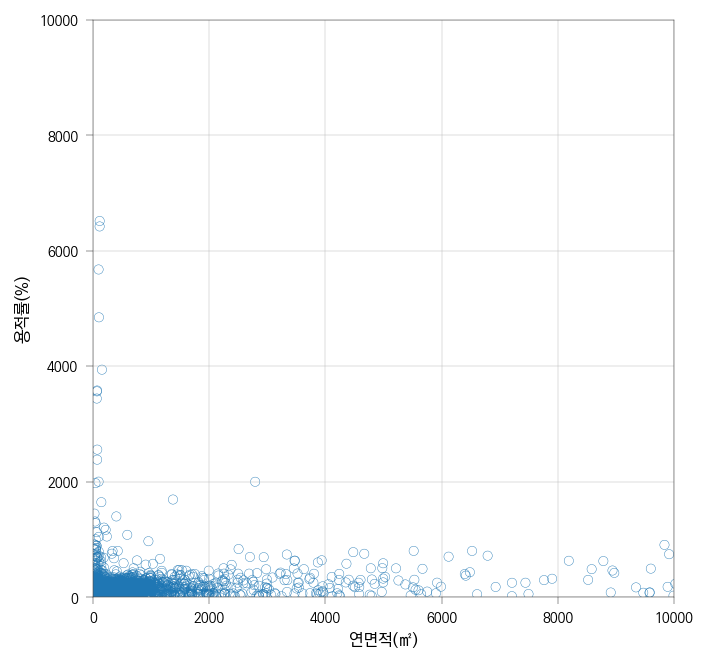

In [ ]:
df["건폐율_이상"] = df["건폐_율(%)"] > 100
sampled = stratified_sample(df, "건폐율_이상", n=10_000, min_per_stratum=1_000)

plt.figure(figsize=(5, 5))
colors = sampled["건폐율_이상"].map({True: "tab:red", False: "tab:blue"})
plt.scatter(
    sampled["연면적(㎡)"],
    sampled["용적_률(%)"],
    # edgecolors=colors,
    edgecolors="tab:blue",
    facecolors="none",
    s=20,
)
max_xval = 10_000
max_yval = 10_000
plt.xlim(0, max_xval)
plt.ylim(0, max_yval)

# line
# plt.plot([0, max_xval], [100, 100], color="tab:gray", linestyle="--", linewidth=1)

# Shade area above the line
# plt.fill_between(
#     [0, max_xval],
#     [100, 100],
#     [max_yval, max_yval],
#     color="tab:red",
#     alpha=0.10,
#     zorder=0,
# )

plt.xlabel("연면적(㎡)")
plt.ylabel("용적률(%)")
plt.grid(True)

In [139]:
# from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

from sklearn.inspection import DecisionBoundaryDisplay


In [200]:
sampled = df.sample(n=10_000, replace=False, random_state=1106)
X = sampled[["연면적(㎡)", "용적_률(%)"]].dropna().values
X[:, 0] = np.log1p(X[:, 0])  # log transform 연면적
# X_train, X_test = train_test_split(X, test_size=0.2, random_state=1106)

clf = LocalOutlierFactor()
y_pred = clf.fit_predict(X)
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))


{np.int64(-1): np.int64(330), np.int64(1): np.int64(6559)}


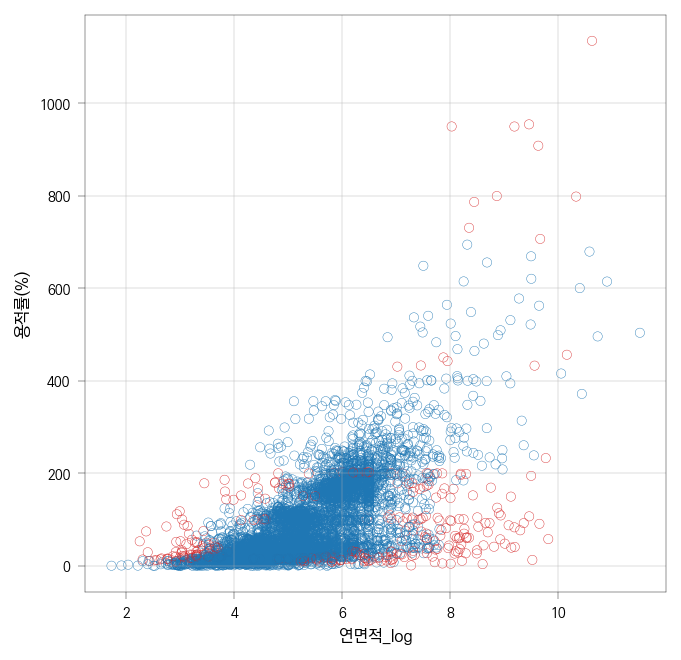

: 

In [ ]:
plt.figure(figsize=(5, 5))
colors = np.where(y_pred == -1, "tab:red", "tab:blue")
# disp = DecisionBoundaryDisplay.from_estimator(
#     clf,
#     X,
#     response_method="decision_function",
    # alpha=0.5,
    # ax=plt.gca(),
# )
plt.scatter(
    X[:, 0],
    X[:, 1],
    edgecolors=colors,
    facecolors="none",
    s=20,
)
# max_xval = 10_000
# max_yval = 10_000
# plt.xlim(0, max_xval)
# plt.ylim(0, max_yval)
plt.xlabel("연면적_log")
plt.ylabel("용적률(%)")
plt.grid(True)

(1000, 2) float64


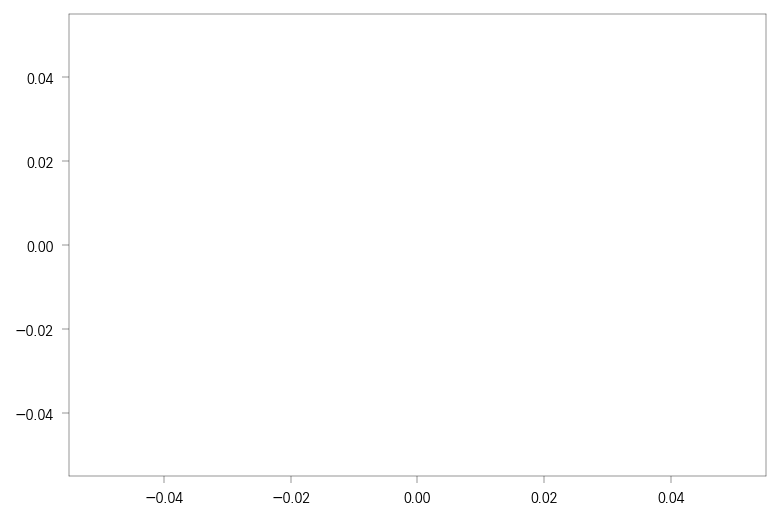

In [196]:
sampled = df.sample(n=1_000, replace=False, random_state=1106)
X = sampled[["연면적(㎡)", "용적_률(%)"]].values
X_train, X_test = train_test_split(X, test_size=0.2, random_state=1106)

clf = IsolationForest(random_state=1106)
clf.fit(X_train)

print(X.shape, X.dtype)


disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    alpha=0.5,
)

(280, 2) float64


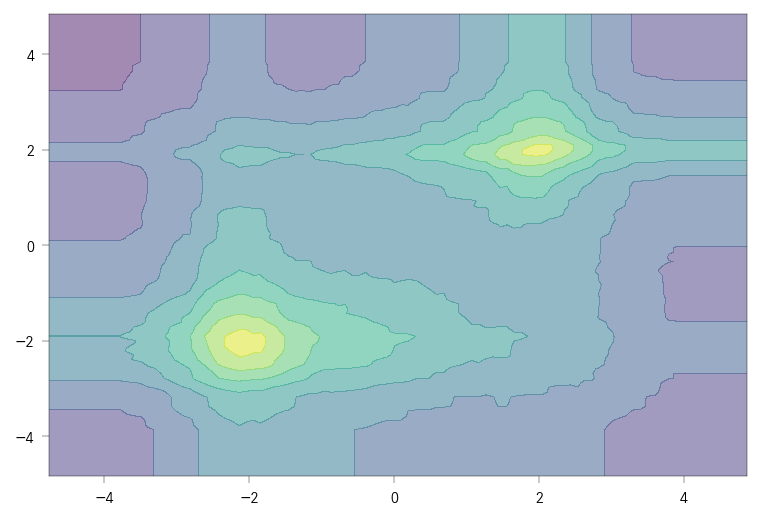

In [195]:
import numpy as np

from sklearn.model_selection import train_test_split

n_samples, n_outliers = 120, 40
rng = np.random.RandomState(0)
covariance = np.array([[0.5, -0.1], [0.7, 0.4]])
cluster_1 = 0.4 * rng.randn(n_samples, 2) @ covariance + np.array([2, 2])  # general
cluster_2 = 0.3 * rng.randn(n_samples, 2) + np.array([-2, -2])  # spherical
outliers = rng.uniform(low=-4, high=4, size=(n_outliers, 2))

X = np.concatenate([cluster_1, cluster_2, outliers])
print(X.shape, X.dtype)

X_train, X_test = train_test_split(X, random_state=42)

from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=100, random_state=0)
clf.fit(X_train)

disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="decision_function",
    alpha=0.5,
)
# scatter = disp.ax_.scatter(X[:, 0], X[:, 1], s=20, edgecolor="k")
# disp.ax_.set_title("Path length decision boundary \nof IsolationForest")
# plt.axis("square")
# plt.colorbar(disp.ax_.collections[1])
# plt.show()